In [122]:
import pandas as pd
import ipynb
from ipynb.fs.full.Functions import check_categories, check_position, rec_similar_players, get_projected_ws

import streamlit as st

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

# Context:
###### OH NO! The player you wanted to draft for your fantasy team is unavailable! Who should you pick?
<br>
This might help

# Models

In [5]:
# Load the data 
df_3p_era = pd.read_pickle('final_df.pickle')

In [17]:
# Alter dataframe to get rid of duplicates 
dupes = df_3p_era[df_3p_era.duplicated(['pid','age'],keep=False)].sort_values(by=['player','g'],ascending=False)
data = df_3p_era.drop(dupes.index)
data = pd.concat([data, dupes[dupes.tm == 'TOT']])

data = data.rename(columns={'3p':'fg3',
                   '3pa':'fg3a',
                   '2p':'fg2',
                   '2pa':'fg2a',
                   '3p_pct':'fg3_pct',
                   '2p_pct':'fg2_pct'})

# Recommendations

## Recommending Players

In [138]:
recs = rec_similar_players()
recs

Possible categories: 
 1. Points (pts) 
 2. Rebounds (trb) 
 3. Assists (ast) 
 4. Steals (stl) 
 5. Blocks (blk) 
 6. Turnovers (tov) 
 7. Field goal percentage (fg_pct) 
 8. Mid-range Field goal percentage (fg2_pct) 
 9. 3-point percentage (fg3_pct) 
 10: Free-throw percentage (ft_pct) 
 11: Win Share (ws)

(Optional) 
Please select categories, ordered by importance (Separated by commas(,)): 
5,2,3,1,7
Please input player name: 
lebron james

Possible positions: 
 1. PG (Point Guard) 
 2. SG (Shooting Guard)
 3. SF (Small Forward)
 4. PF (Power Forward)
 5. C  (Center)

(Optional) 
Please specify position: 
3


,player,pos,blk,trb,ast,pts,fg_pct
0,Lebron James,SF,33,465,454,1505,0.510
1,Khris Middleton,SF,7,461,331,1407,0.441
2,Kawhi Leonard,SF,24,439,199,1596,0.496
3,Danilo Gallinari,SF,23,417,178,1346,0.463
4,Bojan Bogdanović,SF,1,333,161,1454,0.497
5,Andrew Wiggins,SF,48,352,184,1321,0.412
6,Jayson Tatum,SF,57,477,168,1243,0.450
7,Kevin Durant,SF,84,497,457,2027,0.521
8,Cedi Osman,SF,11,357,195,991,0.427
9,Trevor Ariza,SF,21,371,252,863,0.399


## Given the recommended players, display projected win-shares for next season

##### Why win share?
In this dataset, there were two metrics to quantify performance. 
<br>
One was PER (Player Efficiency Rating), which is a per-minute rating of a player's performance. It assigns carefully calculated coefficients to various player stats and aggregates this into a rating. 
<br>
The other was WS (Win Share), which calculates how much a player's performance contributed to a team's success.
<br>
With Yahoo's fantasy basketball league scoring system, I calculated how many fantasy points each player accrued for each season he played (from 1980 to 2019). 
<br>
<br>
Since this is the direct performance claculation for fantasy basketball, determine which NBA metric would be better at predicting this fantasy basketball metric.
<br>
<br>
THE ONE WITH HIGHER CORRELATION TO FANTASY POINTS IS BETTER!!

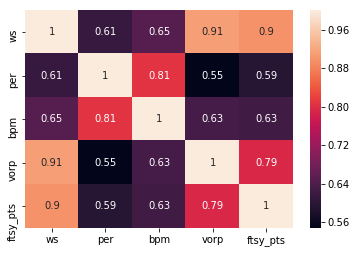

In [132]:
# Correlation between fantasy points and NBA metrics 
sns.heatmap(df_3p_era[['ws','per','bpm','vorp','ftsy_pts']].corr(), annot=True)
# ff.create_annotated_heatmap(df_3p_era[['ws','per','bpm','vorp','ftsy_pts']].corr())

##### Show win share projections for each player

In [135]:
get_projected_ws(recs)

,player,pos,pts,trb,stl,projected_ws
0,James Harden,PG,2818,518,158,27.628349
1,Paul George,SF,2159,628,170,21.253915
2,Bradley Beal,SG,2099,411,121,18.169216
3,Kevin Durant,SF,2027,497,58,21.049306
4,Kemba Walker,PG,2102,361,102,17.155297
5,Damian Lillard,PG,2067,371,88,20.163179
6,Blake Griffin,PF,1841,565,52,15.841684
7,Stephen Curry,PG,1881,369,92,18.059614
8,Donovan Mitchell,SG,1829,316,106,11.514747
9,Giannis Antetokounmpo,PF,1994,898,92,25.320664


# Comparing all seasons (1980 - 2019)

In [130]:
# Distribution of win shares 
ff.create_distplot([list(data.ws)], ['Win Shares'])

In [116]:
# Just a basic count of players for each season in dataset 
basic_count = data.groupby('season').count()[['player']].reset_index()
p_count_fig = go.Figure(go.Bar(x=basic_count.season, y=basic_count.player))
p_count_fig.show()


In [11]:
# Display trend of positions over the years 
pos_season_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season','pos']).count()[['player']].unstack()

names = list(set(pos_season_df.player.columns))

# create a container for each go.Bar instance
lines = []

# loop through the names list which is each player class 
for i in range(len(names)):
    # dictionary with necessary arguments to graph
    line_dict = dict(name=names[i], x=pos_season_df.index, y=pos_season_df.player[names[i]])
    # add to bars container
    lines.append(line_dict)

# set fig1 to the Figure instance
fig_trend = go.Figure(lines)

fig_trend.update_layout(
    title=go.layout.Title(
        text="Position Trend",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Position Count",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

fig_trend.show()

In [100]:
# Display trend of total stats over the years 
scoring_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season']).sum()[['g','mp','pts','trb','ast','stl','blk','tov','ws']]

value_names = list(scoring_df.columns)

# create a container for each go.Bar instance
lines = []

# loop through the names list which is each player class 
for i in range(len(value_names)):
    # dictionary with necessary arguments to graph
    line_dict = dict(name=value_names[i], x=scoring_df.index, y=scoring_df[value_names[i]])
    # add to bars container
    lines.append(line_dict)

# set fig1 to the Figure instance
stats_trend = go.Figure(lines)

stats_trend.update_layout(
    title=go.layout.Title(
        text="Total Stats Trend",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Stats Totals",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

stats_trend.show()

In [103]:
# Display trend of average stats over the years 
avg_scoring_df = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season']).mean()[['g','mp','pts','trb','ast','stl','blk','tov','ws']]

value_names = list(avg_scoring_df.columns)

# create a container for each go.Bar instance
lines = []

# loop through the names list which is each player class 
for i in range(len(value_names)):
    # dictionary with necessary arguments to graph
    line_dict = dict(name=value_names[i], x=avg_scoring_df.index, y=avg_scoring_df[value_names[i]])
    # add to bars container
    lines.append(line_dict)

# set fig1 to the Figure instance
stats_trend = go.Figure(lines)

stats_trend.update_layout(
    title=go.layout.Title(
        text="Average Stats Trend",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Stats Totals",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

stats_trend.show()

In [27]:
# Shooting percentages by season 
field_goals = data.groupby('season').mean()[['fg_pct','fg2_pct','fg3_pct','ft_pct']]
lines = []
lines.append(dict(name='3-Point Percentage', x=field_goals.index, y=field_goals.fg3_pct))
lines.append(dict(name='Mid-range FG Percentage', x=field_goals.index, y=field_goals.fg2_pct))
lines.append(dict(name='Overall FG Percentage', x=field_goals.index, y=field_goals.fg_pct))
lines.append(dict(name='Free Throw Percentage', x=field_goals.index, y=field_goals.ft_pct))
go.Figure(lines)

In [133]:
# Shooting percentages of each position over the seasons
plop = df_3p_era[df_3p_era.tm != 'TOT'].groupby(['season','pos']).mean()[['fg_pct','3p_pct']].unstack()

a,b = plop.columns.levels

lines = []

feature = list(a)
position = list(b)
names = [nam+'_'+nom.replace('_pct','%').upper() for nom in a for nam in b]

for f in feature:
    for posit in position:
        lines.append(dict(x=plop.index, y=plop[f][posit]))
for i in range(len(lines)):
    lines[i]['name'] = names[i]
    
sht_pct = go.Figure(lines)

sht_pct.update_layout(
    title=go.layout.Title(
        text="Shooting Percentage of Positions",
        xref="paper",
        x=0.5,
        y=0.85,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Seasons",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Shooting Percentage",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

In [13]:
# Display win share vs minutes played 
mp_ws = data.groupby(['player','season']).sum().reset_index()

mp_vs_ws_fig = px.scatter(mp_ws, x='mp', y='ws', color='experience')

mp_vs_ws_fig.update_layout(
    title=go.layout.Title(
        text="Minutes Played VS Win Share",
        xref="paper",
        x=0.5,
        y=0.95,
        font=dict(
            size=20)
    ),
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Minutes Played",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Win Share",
            font=dict(
#                 family="Courier New, monospace",
                size=15,
                color="#7f7f7f"))))

mp_vs_ws_fig.show()

In [26]:
# Graphing total win shares distributed by class per season 
# creating dataframe for graph
grouped_szn_exp = data.groupby(['season','experience'])
player_sum_df = grouped_szn_exp.sum().reset_index()

fig2 = px.scatter_3d(player_sum_df, x='season', y='experience', z='ws', color='experience')

fig2.update_layout(
    title=go.layout.Title(
        text="Total Win Share by Experience per Season",
        xref="paper",
        x=0.5,
        y=0.95,
        font=dict(
            size=20)))

fig2.show()

In [25]:
# Graphing average win shares distributed by class per season
fig4 = px.scatter_3d(grouped_szn_exp.mean().reset_index(), x='season', y='experience', z='ws', color='experience')

fig4.update_layout(
    title=go.layout.Title(
        text="Average Win Share by Experience per Season",
        xref="paper",
        x=0.5,
        y=0.95,
        font=dict(
            size=20)))

fig4.show()